# Assignment 1 — Descriptive Analysis of District-Level Structural Data (EU 2024)

**Group:** Linus Wössner, Alens Laskovs, Jingyang Zhao  
**Course:** Internet & Database Technology  
**Dataset:** Structural indicators at district level, Statistische Ämter des Bundes und der Länder  
**File:** `data/ew24_structure_data.xlsx`

## Objective  
Conduct a **thorough descriptive analysis** of German districts.

## Evaluation Criteria  
- **Completeness and executability of the program code appropriate to the task**
- **Efficiency of the code** 
- **Robustness of the code** 
- **Comments and explanations of why certain parameters and a sequence of steps were used**  
- **Structure of the Jupyter Notebook**
- **Line of Argumentation**

## Analysis Roadmap  
Our process moves from *raw data* to *interpretable insights* in four steps:

1. **Data Understanding**  
   Check data types, duplicates, and missing values to ensure reliability.  
   *Guiding question:* *Do we understand what we are analyzing?*  

2. **Data Preparation**  
   Standardize variables (e.g., units, formats, percentages) to create a consistent base for analysis.  

3. **Descriptive Analysis**  
   Use statistics and visualizations to explore distributions, variation, and relationships across districts. Interpret results to highlight key structural differences.  

4. **Conclusion**  
   Summarize findings into clear, evidence-based takeaways that answer:  
   *“What do the structural data reveal about German districts ahead of the 2024 European election?”*  


# Step 1 — Data Understanding

We begin by checking the dataset for structural and quality issues to ensure the analysis is **robust and interpretable**.  
This step verifies that the raw data is suitable for statistical summaries and flags areas needing further preparation.

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# ----------------------------------------------------------------------
# NOTE TO PROFESSOR PRAUSE:
# Please update the file_path below so it points to the location of
# "ew24_structure_data.xlsx" on your computer.
# ----------------------------------------------------------------------
file_path = '/Users/linuswossner/Desktop/database/Database-and-Techbology/ew24_structure_data.xlsx'

# Load the dataset and keep "District" as string
idt_df = pd.read_excel(file_path, dtype={'District': str})
# Dataset is stored as idt_df

# 1) Check basic dataset information
print("\nDataset Information:")
idt_df.info()

print("\nFirst 5 rows:")
print(idt_df.head())

# 2) Check for duplicate rows
duplicates = idt_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 52 columns):
 #   Column                                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                                               --------------  -----  
 0   Land                                                                                                                                 441 non-null    object 
 1   District                                                                                                                             441 non-null    object 
 2   Name                                                                                                                                 441 non-null    object 
 3   Municipalities                                            

## Step 1 — Data Understanding — Conclusion

1. **Structure**  
   - Dataset: **444 rows**, **52 columns**.  
   - Germany has **400 districts** (294 rural, 106 urban; 2024, Federal Returning Officer).  
   - Extra rows beyond 400 must be removed to match the correct unit of analysis.  

2. **Data Types**  
   - Most variables are numeric.  
   - ~10 are stored as `object` despite containing numeric values (e.g., `Area in km²`).  
   - These will be converted to numeric in the preparation step.  

3. **Missingness**  
   - All variables show 3 missing values (441 non-null).  
   - We must check if missingness is systematic or random.  

4. **Duplicates**  
   - **1 duplicate row** detected.  
   - Needs validation as error or legitimate repeat.  

**Conclusion:**  
The dataset is suitable for district-level analysis but requires adjustments:  
- Remove rows beyond the 400 official districts.  
- Convert misclassified variables to numeric.  
- Address missing and duplicate values.  

**Data Reliability:**  
The data originates from the *Statistische Ämter des Bundes und der Länder*, part of the **European Statistical System (ESS)**, which follows the **European Statistics Code of Practice** (Eurostat, 2017). This institutional framework ensures high standards of accuracy and comparability. Our checks complement these safeguards by ensuring consistency and interpretability.  

With these sanity checks complete, we proceed to **Step 2 — Data Preparation**, where we clean and standardize the dataset for descriptive analysis.


## Step 2 — Data Preparation  

This step transforms the raw dataset into a format suitable for district-level descriptive analysis.  
Although the data comes from an official source, our checks revealed issues that must be resolved before computing statistics.  

The main tasks are:  

1. **Restrict to districts**  
   - Remove non-district rows (e.g., `"Deutschland"` totals).  
   - Ensure the dataset matches the official **400 districts**.  

2. **Correct data types**  
   - Convert numeric variables stored as `object` into proper numeric formats.  
   - Keep categorical variables (e.g., `Land`) for grouping and comparison.  

3. **Standardize percentages**  
   - Express all percentage variables on a consistent 0–100 scale for comparability.  


## 2.1 Restricting the dataset to districts


Distribution of District name lengths (NaN shown if present):
District
2        41
5       400
<NA>      3
Name: count, dtype: Int64

Mean length: 4.72
Median length: 5
Most common length(s): [5]


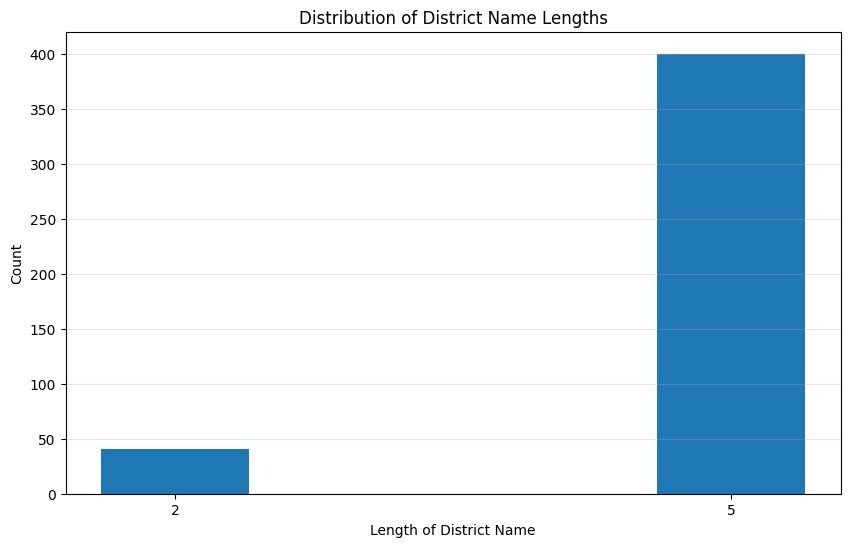


Unusual lengths using IQR rule (k=1.5): < 5 or > 5
Number of rows with unusual District lengths: 41

Sample of rows with unusual District lengths:
    District  district_length
15        01                2
16        01                2
17        01                2
64        03                2
65        03                2
66        03                2
69        04                2
123       05                2
124       05                2
125       05                2


In [23]:
# District name length analysis
col = "District"
if col in idt_df.columns:
    # Clean text and compute lengths (vectorized, robust to NaNs)
    s = (
        idt_df[col]
        .astype("string")              # pandas string dtype (keeps NaN)
        .str.normalize("NFC")          # normalize unicode (ä, ö, ü, ß, etc.)
        .str.strip()                   # remove leading/trailing spaces
    )
    lengths = s.str.len()              # vectorized length (NaN stays NaN)

    # 1) Add the column so you can filter later
    idt_df["district_length"] = lengths

    # 2) Distribution (include NA count separately)
    length_counts = lengths.value_counts(dropna=False).sort_index()
    print("\nDistribution of District name lengths (NaN shown if present):")
    print(length_counts)

    # 3) Summary stats (guard for empty/NA-only)
    non_na = lengths.dropna()
    if non_na.empty:
        print("\nNo non-missing values to summarize.")
    else:
        mean_len = non_na.mean()
        median_len = non_na.median()
        modes = non_na.mode().astype(int).tolist()  # could be multiple
        print(f"\nMean length: {mean_len:.2f}")
        print(f"Median length: {int(median_len)}")
        print(f"Most common length(s): {modes}")

        # Visualize (integer x-ticks)
        vc = non_na.value_counts().sort_index()
        plt.figure(figsize=(10, 6))
        plt.bar(vc.index, vc.values)
        plt.xlabel("Length of District Name")
        plt.ylabel("Count")
        plt.title("Distribution of District Name Lengths")
        plt.grid(axis="y", alpha=0.3)
        # Optional: show all integer ticks if range is small
        if vc.index.max() - vc.index.min() <= 40:
            plt.xticks(vc.index)
        plt.show()

        # 4) Unusual lengths via IQR rule (more principled than mode±k)
        q1, q3 = non_na.quantile([0.25, 0.75])
        iqr = q3 - q1
        k = 1.5  # adjust if you want stricter/looser
        lower, upper = q1 - k * iqr, q3 + k * iqr
        mask = (lengths < lower) | (lengths > upper)

        unusual = idt_df.loc[mask, [col]].copy()
        unusual["district_length"] = lengths[mask]

        print(
            f"\nUnusual lengths using IQR rule (k={k}): "
            f"< {int(lower)} or > {int(upper)}"
        )
        print(f"Number of rows with unusual District lengths: {len(unusual)}")
        if not unusual.empty:
            print("\nSample of rows with unusual District lengths:")
            print(unusual.head(10))
            # To keep only typical lengths:
            # typical_df = idt_df.loc[~mask].copy()
            # print(f"\nRemaining rows after filtering: {len(typical_df)}")
else:
    print(f"Column '{col}' not found in the dataframe.")


To restrict the dataset to valid districts, we filtered by district identifier length.  
Only identifiers with **5 characters** correspond to official districts; shorter ones (non-district entries) were removed.  
This yields the official total of **400 districts**.

In [24]:
# Remove rows with District length shorter than 5
dist_df = idt_df[idt_df['district_length'] >= 5].copy()

# Print summary of the filtering
print(f"Original DataFrame: {len(idt_df)} rows")
print(f"Filtered DataFrame: {len(dist_df)} rows")
print(f"Removed {len(idt_df) - len(dist_df)} rows with District length < 5 or NaN")

# Check the distribution of district lengths in the filtered DataFrame
length_counts = dist_df['district_length'].value_counts().sort_index()
print("\nDistrict length distribution in district-only DataFrame:")
print(length_counts)

# Optional: Reset the index of the new DataFrame
dist_df.reset_index(drop=True, inplace=True)

# Display a sample of the filtered DataFrame
print("\nSample of filtered DataFrame:")
display(dist_df.head())

Original DataFrame: 444 rows
Filtered DataFrame: 400 rows
Removed 44 rows with District length < 5 or NaN

District length distribution in district-only DataFrame:
district_length
5    400
Name: count, dtype: Int64

Sample of filtered DataFrame:


,Land,District,Name,Municipalities,Area in km2,Population on 31.12.2022 - Total (in 1000),Population on 31.12.2022 - German (in 1000),Population on 31.12.2022 - Foreigners (%),Population density on 31.12.2022 (inhabitants per km2),Increase (+) or decrease (-) in population in 2022 - Birth balance (per 1000 inhabitants),...,"Social insurance contributions as of 30.06.2023 - Other service providers and ""unspecified"" (%)",Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants),Recipients of benefits under SGB II in August 2023 - Non-working individuals in need (%),Recipients of benefits under SGB II in August 2023 - Foreigners (%),Unemployment rate in October 2023 - Total,Unemployment rate in October 2023 - Men,Unemployment rate in October 2023 - Women,Unemployment rate in October 2023 - 15 to 24 years,Unemployment rate in October 2023 - 55 to 64 years,district_length
0,Schleswig-Holstein,01001,"Flensburg, Stadt",1.0,56.7,92.6,75.5,18.5,1631.4,-4.2,...,40.0,115.1,25.3,37.9,7.8,8.4,7.0,6.0,7.5,5
1,Schleswig-Holstein,01002,"Kiel, Landeshauptstadt",1.0,118.7,247.7,214.1,13.6,2087.8,-2.9,...,39.8,120.5,26.1,41.0,7.5,7.9,7.1,5.3,7.9,5
2,Schleswig-Holstein,01003,"Lübeck, Hansestadt",1.0,214.2,218.1,190.8,12.5,1018.2,-6.7,...,32.5,104.9,25.7,35.9,7.6,8.1,7.1,6.6,7.6,5
3,Schleswig-Holstein,01004,"Neumünster, Stadt",1.0,71.7,79.5,68.3,14.2,1109.4,-7.1,...,26.6,112.0,26.3,35.6,8.2,8.4,8.0,8.0,7.6,5
4,Schleswig-Holstein,01051,Dithmarschen,116.0,1428.2,135.3,124.8,7.8,94.7,-7.6,...,32.3,74.6,26.9,35.2,5.5,5.8,5.2,5.8,5.2,5


## 2.2 Data Type Corrections  

We converted variables stored as `object` into proper numeric types so they can be used in calculations.  
After conversion, we re-checked for **missing values** and **duplicates** to confirm consistency before analysis.  

In [25]:
# Column indices to convert to numeric (float)
columns_to_convert = [4, 28, 33, 39, 40, 41, 42]

# Validate indices against current DataFrame shape
valid_idx = [i for i in columns_to_convert if 0 <= i < dist_df.shape[1]]
invalid_idx = sorted(set(columns_to_convert) - set(valid_idx))
if invalid_idx:
    print(f"Warning: Ignoring invalid column indices (out of bounds): {invalid_idx}")

# Resolve column names from indices
cols = dist_df.columns[valid_idx].tolist()
print("Converting the following columns to numeric (float):")
for i, name in zip(valid_idx, cols):
    print(f"Index {i}: {name}")

# Capture dtypes before conversion
dtypes_before = dist_df[cols].dtypes.astype(str)

# Vectorized conversion (coerce non-numeric to NaN)
dist_df[cols] = dist_df[cols].apply(pd.to_numeric, errors="coerce")

# Build a concise report
dtypes_after = dist_df[cols].dtypes.astype(str)
nan_counts = dist_df[cols].isna().sum()

summary = (
    pd.DataFrame({
        "column": cols,
        "dtype_before": dtypes_before.values,
        "dtype_after": dtypes_after.values,
        "nan_after": nan_counts.values,
    })
    .sort_values("column")
    .reset_index(drop=True)
)

print("\nConversion summary:")
print(summary.to_string(index=False))

# DataFrame summary AFTER modifications
print("\nDataFrame info after modifications:")
dist_df.info()

# Show a sample of the converted data (Jupyter-friendly)
print("\nSample of DataFrame with converted columns:")
display(dist_df[cols].head())


Converting the following columns to numeric (float):
Index 4: Area in km2
Index 28: School graduates from vocational schools 2022 (per 1000 inhabitants)
Index 33: School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)
Index 39: Social insurance contributions as of 30.06.2023 - Agriculture, forestry, fishing (%)
Index 40: Social insurance contributions as of 30.06.2023 - Manufacturing industry (%)
Index 41: Social insurance contributions as of 30.06.2023 - Trade, hospitality, transport (%)
Index 42: Social insurance contributions as of 30.06.2023 - Public and private service providers (%)

Conversion summary:
                                                                                                                             column dtype_before dtype_after  nan_after
                                                                                                                        Area in km2       o

,Area in km2,School graduates from vocational schools 2022 (per 1000 inhabitants),School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%),"Social insurance contributions as of 30.06.2023 - Agriculture, forestry, fishing (%)",Social insurance contributions as of 30.06.2023 - Manufacturing industry (%),"Social insurance contributions as of 30.06.2023 - Trade, hospitality, transport (%)",Social insurance contributions as of 30.06.2023 - Public and private service providers (%)
0,56.7,8.0,43.9,NaN,NaN,25.4,19.2
1,118.7,5.6,44.0,NaN,NaN,19.1,25.6
2,214.2,4.0,39.0,0.1,23.6,23.1,20.7
3,71.7,7.8,43.3,0.8,19.8,31.5,21.3
4,1428.2,2.2,28.4,4.1,24.8,27.5,11.3


After converting object columns to numeric, some variables now show missing values (`NaN`) where symbols or placeholders could not be parsed.  
While not visible in the raw data, treating them as explicit missing values avoids distorted statistics.  

Since datasets rarely have complete coverage, acknowledging missingness is essential. We will revisit the missingness analysis at a later point in time. 


In [26]:
# Total rows
total_rows = len(dist_df)
print(f"Total rows in dist_df: {total_rows}")

# Missing values per column
missing = dist_df.isna().sum()
incomplete = missing[missing > 0]

print(f"\nFound {len(incomplete)} columns with missing values:")
for col_name, count in incomplete.items():
    percent = (count / total_rows) * 100
    print(f"  {col_name}: {count} missing values ({percent:.2f}%)")

# Summary DataFrame (sorted by most missing)
missing_summary = (
    pd.DataFrame({
        "Column": incomplete.index,
        "Missing Count": incomplete.values,
        "Missing Percentage": (incomplete.values / total_rows * 100).round(2),
    })
    .assign(**{"Non-null Count": total_rows - incomplete.values})
    .sort_values("Missing Count", ascending=False)
)

print("\nSummary of columns with missing values (sorted by most missing):")
display(missing_summary)

Total rows in dist_df: 400

Found 6 columns with missing values:
  School graduates from vocational schools 2022 (per 1000 inhabitants): 5 missing values (1.25%)
  School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%): 2 missing values (0.50%)
  Social insurance contributions as of 30.06.2023 - Agriculture, forestry, fishing (%): 20 missing values (5.00%)
  Social insurance contributions as of 30.06.2023 - Manufacturing industry (%): 10 missing values (2.50%)
  Social insurance contributions as of 30.06.2023 - Trade, hospitality, transport (%): 2 missing values (0.50%)
  Social insurance contributions as of 30.06.2023 - Public and private service providers (%): 8 missing values (2.00%)

Summary of columns with missing values (sorted by most missing):


,Column,Missing Count,Missing Percentage,Non-null Count
2,Social insurance contributions as of 30.06.202...,20,5.00,380
3,Social insurance contributions as of 30.06.202...,10,2.50,390
5,Social insurance contributions as of 30.06.202...,8,2.00,392
0,School graduates from vocational schools 2022 ...,5,1.25,395
1,School graduates from general education school...,2,0.50,398
4,Social insurance contributions as of 30.06.202...,2,0.50,398


## 2.3 Standardizing Percentage Variables  

Some percentage variables may use inconsistent scales.  
We converted all to a **0–100 scale** to ensure comparability across districts.  

This prevents distortions in statistics and visualizations, making all proportions consistently interpretable as percentages out of 100. 

In [27]:
# Define the specific columns to process (by index)
columns_to_process = [7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 25, 30, 31, 32, 33, 39]

# Validate indices and resolve names
valid_idx = [i for i in columns_to_process if 0 <= i < dist_df.shape[1]]
invalid_idx = sorted(set(columns_to_process) - set(valid_idx))
if invalid_idx:
    print(f"Warning: ignoring out-of-bounds indices: {invalid_idx}")

cols = dist_df.columns[valid_idx].tolist()

# Create an empty DataFrame to store standardization statistics
stats_df = pd.DataFrame(columns=[
    'Column', 'Original_Min', 'Original_Max', 'Original_Mean',
    'Standardized_Min', 'Standardized_Max', 'Standardized_Mean', 'Conversion_Applied'
])

for col in cols:
    # Work on a numeric view (won't modify until we assign back)
    s = pd.to_numeric(dist_df[col], errors='coerce')

    # Original stats (skip NaNs)
    orig_min = s.min(skipna=True)
    orig_max = s.max(skipna=True)
    orig_mean = s.mean(skipna=True)

    conversion_applied = "No conversion needed (already in 0–100 range)"

    # Handle all-NaN columns early
    if pd.isna(orig_min) or pd.isna(orig_max):
        # leave as-is
        new_s = s.copy()
        conversion_applied = "No change (all NaN / non-numeric)"
    # 0–1 to 0–100
    elif (orig_min >= 0) and (orig_max <= 1):
        new_s = s * 100
        conversion_applied = "Multiplied by 100 (0–1 → 0–100)"
    # Outside 0–100 → normalize to 0–100
    elif (orig_max > 100) or (orig_min < 0):
        if orig_max == orig_min:
            # zero-variance column: set to 0 (could also choose 100; pick 0 and document)
            new_s = s.copy()
            new_s.loc[~new_s.isna()] = 0.0
            conversion_applied = f"Zero-variance at {orig_min:.2f} → set to 0"
        else:
            new_s = (s - orig_min) / (orig_max - orig_min) * 100
            conversion_applied = f"Normalized from [{orig_min:.2f}–{orig_max:.2f}] to [0–100]"
    else:
        new_s = s.copy()  # already within 0–100

    # Assign back to DataFrame (preserve NaNs)
    dist_df[col] = new_s

    # New stats
    new_min = new_s.min(skipna=True)
    new_max = new_s.max(skipna=True)
    new_mean = new_s.mean(skipna=True)

    # Append to stats
    stats_df.loc[len(stats_df)] = {
        'Column': col,
        'Original_Min': orig_min,
        'Original_Max': orig_max,
        'Original_Mean': orig_mean,
        'Standardized_Min': new_min,
        'Standardized_Max': new_max,
        'Standardized_Mean': new_mean,
        'Conversion_Applied': conversion_applied
    }

# Display the standardization results
print("\nStandardization Results:")
display(stats_df)



Standardization Results:


,Column,Original_Min,Original_Max,Original_Mean,Standardized_Min,Standardized_Max,Standardized_Mean,Conversion_Applied
0,Population on 31.12.2022 - Foreigners (%),3.5,39.0,12.947000,3.5,39.0,12.947000,No conversion needed (already in 0–100 range)
1,Age on 31.12.2022 - under 16 years (%),11.5,18.0,14.882250,11.5,18.0,14.882250,No conversion needed (already in 0–100 range)
2,Age on 31.12.2022 - 16-17 years (%),1.3,2.3,1.827000,1.3,2.3,1.827000,No conversion needed (already in 0–100 range)
3,Age on 31.12.2022 - 18-24 years (%),4.4,13.4,7.124500,4.4,13.4,7.124500,No conversion needed (already in 0–100 range)
4,Age on 31.12.2022 - 25-34 years (%),6.5,20.0,11.818250,6.5,20.0,11.818250,No conversion needed (already in 0–100 range)
5,Age on 31.12.2022 - 35-59 years (%),29.2,36.8,33.605000,29.2,36.8,33.605000,No conversion needed (already in 0–100 range)
6,Age on 31.12.2022 - 60-74 years (%),13.1,26.2,19.445250,13.1,26.2,19.445250,No conversion needed (already in 0–100 range)
7,Age on 31.12.2022 - 75 years and over (%),7.7,17.3,11.296250,7.7,17.3,11.296250,No conversion needed (already in 0–100 range)
8,Land area by type of actual use on 31.12.2021 ...,5.5,75.4,22.132500,5.5,75.4,22.132500,No conversion needed (already in 0–100 range)
9,Land area by type of actual use on 31.12.2021 ...,24.6,94.5,77.867500,24.6,94.5,77.867500,No conversion needed (already in 0–100 range)


The diagnostic check showed no conversion was needed — all percentage variables were already on a consistent 0–100 scale.  

## Step 2 — Data Preparation — Conclusion  

We completed three key tasks:  
1. Restricted the dataset to the **400 valid districts**.  
2. Converted `object` variables to numeric while preserving categorical ones.  
3. Verified that percentage variables were already on a uniform 0–100 scale.  

The dataset is now structurally consistent, analytically robust, and aligned with the **district-level unit of analysis**.  
Next, we move to **Step 3 — Descriptive Analysis** to explore structural patterns across German districts.  

## Step 3 — Descriptive Analysis  

After cleaning the dataset to 400 districts, the analysis focuses on a **core set of indicators** that political science research highlights as key drivers of electoral outcomes. Instead of scanning all 52 variables, we select one representative variable from each thematic block to ensure interpretability and theoretical grounding.  

The 52 variables in the dataset can be meaningfully grouped into broader thematic blocks (population, economy, welfare, education, etc.). From each block, one representative indicator was selected for analysis, guided by findings in electoral research.  

### Thematic Structure and Selected Indicators  

- **Population Dynamics** → *Population Density*  
  Higher density: progressive parties (SPD, Greens); rural: conservatives/populists (CDU/CSU, AfD).  
  *Ref: Haffert & Mitteregger (2023).*  

- **Migration/Population Composition** → *Share of Foreign Residents*  
  Higher shares: lower far-right support; homogeneous regions: stronger AfD results.  
  *Refs: Kellermann & Winter (2021); Otto & Steinhardt (2014).*  

- **Economy and Employment** → *Disposable Income per Inhabitant*  
  Higher income: incumbents/pro-market parties; lower income/inequality: protest/extremist parties.  
  *Refs: Batool (2008); Batool & Sieg (2009); Dorn et al. (2018).*  

- **Social Welfare and Labor Market** → *Recipients of Social Welfare (SGB II)*  
  Higher welfare reliance: stronger support for left parties; contested in SPD/Die Linke/AfD debates.  
  *Refs: Hohmeyer & Lietzmann (2019); Dostal (2017).*  

- **Business Activity (Economy)** → *Firms per Capita*  
  More firms: progressive/pro-market alignment; structurally weak regions: conservative/populist.  
  *Refs: Kowalewski (2010, 2011).*  

- **Education** → *Higher Education Entrance Qualification (Abitur) Share*  
  Higher attainment: progressive parties; lower attainment: conservative/populist support.  
  *Ref: Ciechanowicz (2017); Quast et al. (2025).*  

---

By linking each thematic block to one theoretically salient indicator, the analysis connects structural district-level conditions with established patterns in German electoral research. As Aristotle reminds us, **“It is the mark of an educated mind to rest satisfied with the degree of precision which the nature of the subject admits, and not to seek exactness where only approximation is possible.”** In this spirit, the selection of one representative indicator per block acknowledges the limits of precision in social science while ensuring theoretical clarity and interpretability.  

## 3.1 Population Density  

We examine inhabitants per km² to capture the **urban–rural divide**, a key structural cleavage in German politics (Haffert & Mitteregger, 2023).  
This indicator highlights variation in urbanization and provides a basis for regional comparisons.  

While we are aware that the Returning Officer already differentiates urban and rural districts, we deliberately rely on inhabitants per km² to construct our own measure. This ensures an **unbiased classification** that is **purely data-driven**, independent of external administrative definitions.

Summary statistics for Population density on 31.12.2022 (inhabitants per km2)
count     400.00
mean      544.08
std       719.26
min        35.60
25%       117.98
50%       204.50
75%       686.48
max      4868.00
Name: Population density on 31.12.2022 (inhabitants per km2), dtype: float64


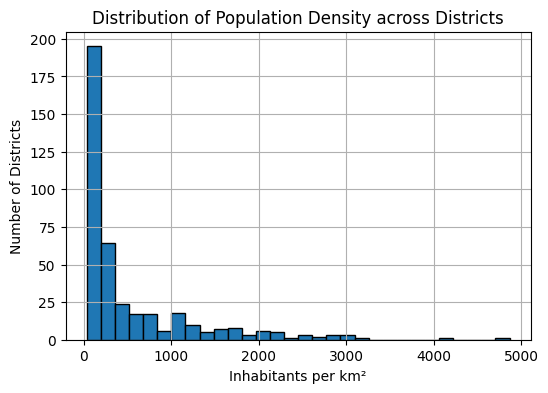

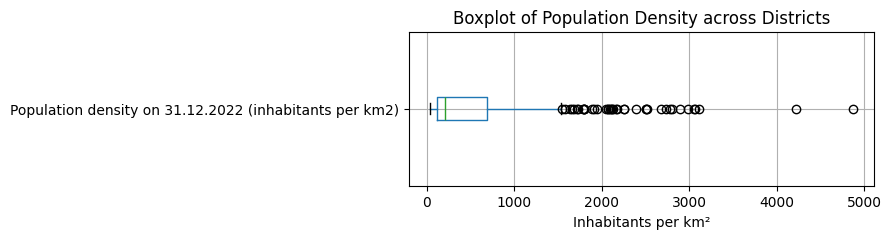


Top 5 districts by population density:
                          Name  \
223  München, Landeshauptstadt   
324              Berlin, Stadt   
117   Frankfurt am Main, Stadt   
108               Herne, Stadt   
178      Stuttgart, Stadtkreis   

     Population density on 31.12.2022 (inhabitants per km2)  
223                                             4868.0       
324                                             4214.1       
117                                             3113.3       
108                                             3060.4       
178                                             3052.5       

Bottom 5 districts by population density:
                       Name  \
339                Prignitz   
367  Altmarkkreis Salzwedel   
342               Uckermark   
337      Ostprignitz-Ruppin   
36        Lüchow-Dannenberg   

     Population density on 31.12.2022 (inhabitants per km2)  
339                                               35.6       
367                          

In [8]:
# Column names
den_col = "Population density on 31.12.2022 (inhabitants per km2)"
label_col = "District"
name_col = "Name"  # The column containing district names

# 1) Summary statistics
print("Summary statistics for", den_col)
print(dist_df[den_col].describe().round(2))

# 2) Histogram
plt.figure(figsize=(6,4))
dist_df[den_col].hist(bins=30, edgecolor="black")
plt.title("Distribution of Population Density across Districts")
plt.xlabel("Inhabitants per km²")
plt.ylabel("Number of Districts")
plt.show()

# 3) Boxplot
plt.figure(figsize=(6,2))
dist_df.boxplot(column=den_col, vert=False)
plt.title("Boxplot of Population Density across Districts")
plt.xlabel("Inhabitants per km²")
plt.show()

# 4) Top 5 and Bottom 5 districts by population density - now showing names
print("\nTop 5 districts by population density:")
print(dist_df[[name_col, den_col]].sort_values(by=den_col, ascending=False).head(5))

print("\nBottom 5 districts by population density:")
print(dist_df[[name_col, den_col]].sort_values(by=den_col, ascending=True).head(5))

**3.1 Interpretation — Population Density**  

The distribution is **right-skewed**:  
- Mean ≈ 544 inh./km² vs. median ≈ 205.  
- Most districts fall below ~700 (75th percentile ≈ 686).  
- A few urban centers reach up to ≈ 4,868 and drive the upper tail.  

This reflects the urban–rural divide: many low-to-moderate density districts contrasted with a small set of very dense cities.  


## 3.2 Share of Foreign Residents  

This indicator captures **demographic diversity**, linked to electoral outcomes:  
- Higher foreign shares → weaker far-right support.  
- More homogeneous districts → stronger AfD alignment (Kellermann & Winter, 2021; Otto & Steinhardt, 2014).  

Descriptive analysis shows how districts differ in foreign population shares and highlights where diversity is concentrated.  

Summary statistics for Population on 31.12.2022 - Foreigners (%)
count    400.00
mean      12.95
std        5.64
min        3.50
25%        8.60
50%       12.00
75%       16.40
max       39.00
Name: Population on 31.12.2022 - Foreigners (%), dtype: float64


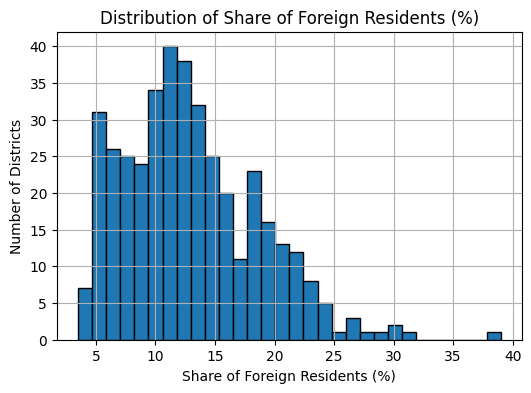

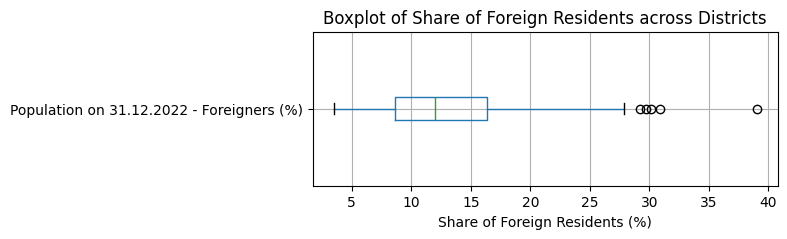


Top 5 districts by percentage foreigners:
                             Name  Population on 31.12.2022 - Foreigners (%)
118      Offenbach am Main, Stadt                                       39.0
117      Frankfurt am Main, Stadt                                       30.9
199         Pforzheim, Stadtkreis                                       30.1
161  Ludwigshafen am Rhein, Stadt                                       29.7
184         Heilbronn, Stadtkreis                                       29.2

Bottom 5 districts by percentage foreigners:
                                 Name  \
352                   Erzgebirgskreis   
357                           Bautzen   
362                           Leipzig   
373                  Mansfeld-Südharz   
360  Sächsische Schweiz-Osterzgebirge   

     Population on 31.12.2022 - Foreigners (%)  
352                                        3.5  
357                                        3.7  
362                                        4.0  
373   

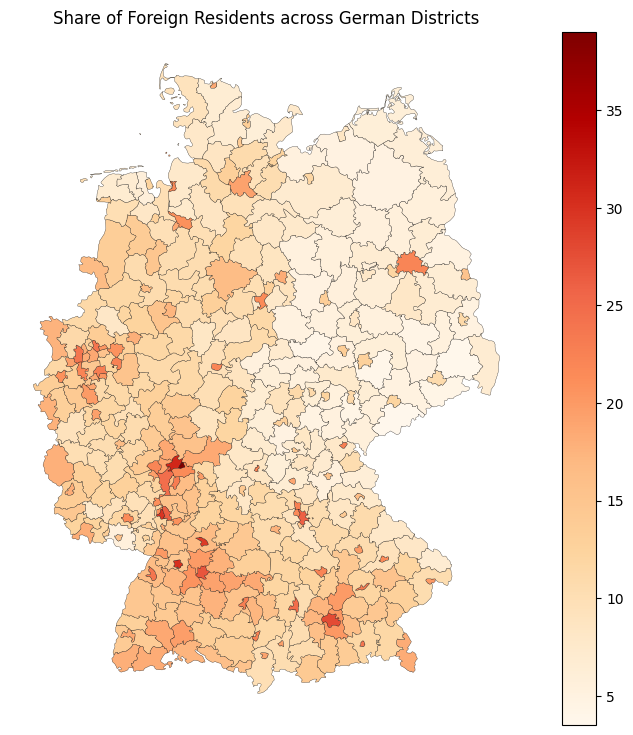

In [9]:
# Column names
foreign_col = "Population on 31.12.2022 - Foreigners (%)"

# 1) Summary statistics
print("Summary statistics for", foreign_col)
print(dist_df[foreign_col].describe().round(2))

# 2) Histogram
plt.figure(figsize=(6,4))
dist_df[foreign_col].hist(bins=30, edgecolor="black")
plt.title("Distribution of Share of Foreign Residents (%)")
plt.xlabel("Share of Foreign Residents (%)")
plt.ylabel("Number of Districts")
plt.show()

# 3) Boxplot
plt.figure(figsize=(6,2))
dist_df.boxplot(column=foreign_col, vert=False)
plt.title("Boxplot of Share of Foreign Residents across Districts")
plt.xlabel("Share of Foreign Residents (%)")
plt.show()

# 4) Top 5 and Bottom 5 districts by share of foreign residents
print("\nTop 5 districts by percentage foreigners:")
print(dist_df[[name_col, foreign_col]].sort_values(by=foreign_col, ascending=False).head(5))

print("\nBottom 5 districts by percentage foreigners:")
print(dist_df[[name_col, foreign_col]].sort_values(by=foreign_col, ascending=True).head(5))

# ----------------------------------------------------------------------
# NOTE TO PROFESSOR PRAUSE:
# Please update the file path below so it points to the location of
# "VG2500_KRS.shp" on your computer.
# IMPORTANT: The .shp file will only work if the other related files
# (.cpg, .dbf, .prj, .shx) are in the SAME folder.
# ----------------------------------------------------------------------
shp_path = "/Users/linuswossner/Library/CloudStorage/OneDrive-WHU/Internet & Database Technology/Assignments/VG2500_KRS.shp"

# 5) Load shapefile
districts = gpd.read_file(shp_path)

# 6) Merge dist_df with geodata
geo_df = districts.merge(dist_df, left_on="AGS", right_on="District", how="inner")

# 7) Example choropleth (pick any numeric column from dist_df)
value_col = "Population on 31.12.2022 - Foreigners (%)"
if value_col in geo_df.columns:
    ax = geo_df.plot(
        column=value_col, cmap="OrRd", legend=True,
        figsize=(10, 9), edgecolor="black", linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("Share of Foreign Residents across German Districts")
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column not found for choropleth: {value_col}")

**3.2 Interpretation — Share of Foreign Residents**  

- **Average:** 13% (median 12%), moderately right-skewed.  
- **Range:** Most districts 9–16% (25th–75th percentile).  
- **Urban centers:** Offenbach (39%), Frankfurt (31%), Pforzheim (30%) among the highest.  
- **Low values:** Saxony and Saxony-Anhalt (e.g., Erzgebirgskreis, Bautzen < 4%).  

This reveals a **regional divide**: western/southwestern urban districts are diverse, while rural eastern districts remain homogeneous.  
The choropleth confirms high concentrations in Rhine-Main, Baden-Württemberg, and Bavaria, with consistently low shares in the East.  

These findings match research showing demographic diversity is unevenly distributed: diverse cities show weaker far-right support, while homogeneous eastern regions are more receptive (Kellermann & Winter, 2021; Otto & Steinhardt, 2014).  

## 3.3 Disposable Income per Inhabitant  

Disposable income measures **regional prosperity** and strongly shapes electoral behavior:  
- Higher income → support for incumbents and pro-market parties (CDU/CSU, FDP).  
- Lower income or high inequality → stronger backing for protest or extremist parties (SPD, Die Linke, AfD) (Batool, 2008; Batool & Sieg, 2009; Dorn et al., 2018).  

Analyzing income at the district level reveals key socio-economic divides across Germany.  

Summary statistics for Disposable income of private households in 2021 (EUR per inhabitant)
count      400.00
mean     24157.00
std       2373.18
min      17116.00
25%      22525.00
50%      24021.00
75%      25581.25
max      37515.00
Name: Disposable income of private households in 2021 (EUR per inhabitant), dtype: float64


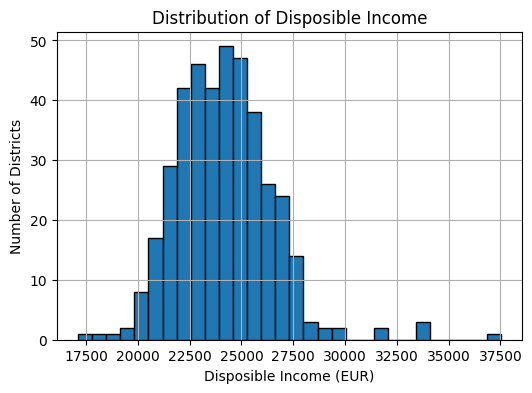

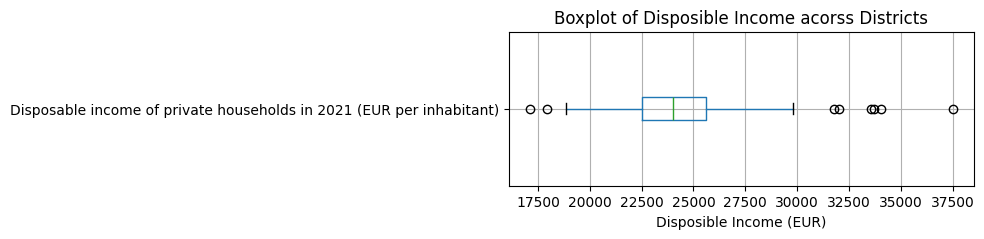

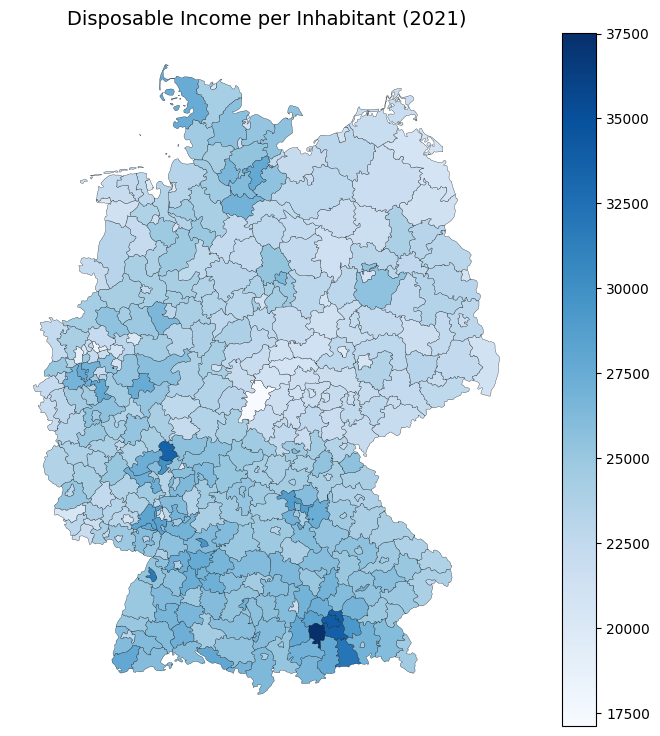

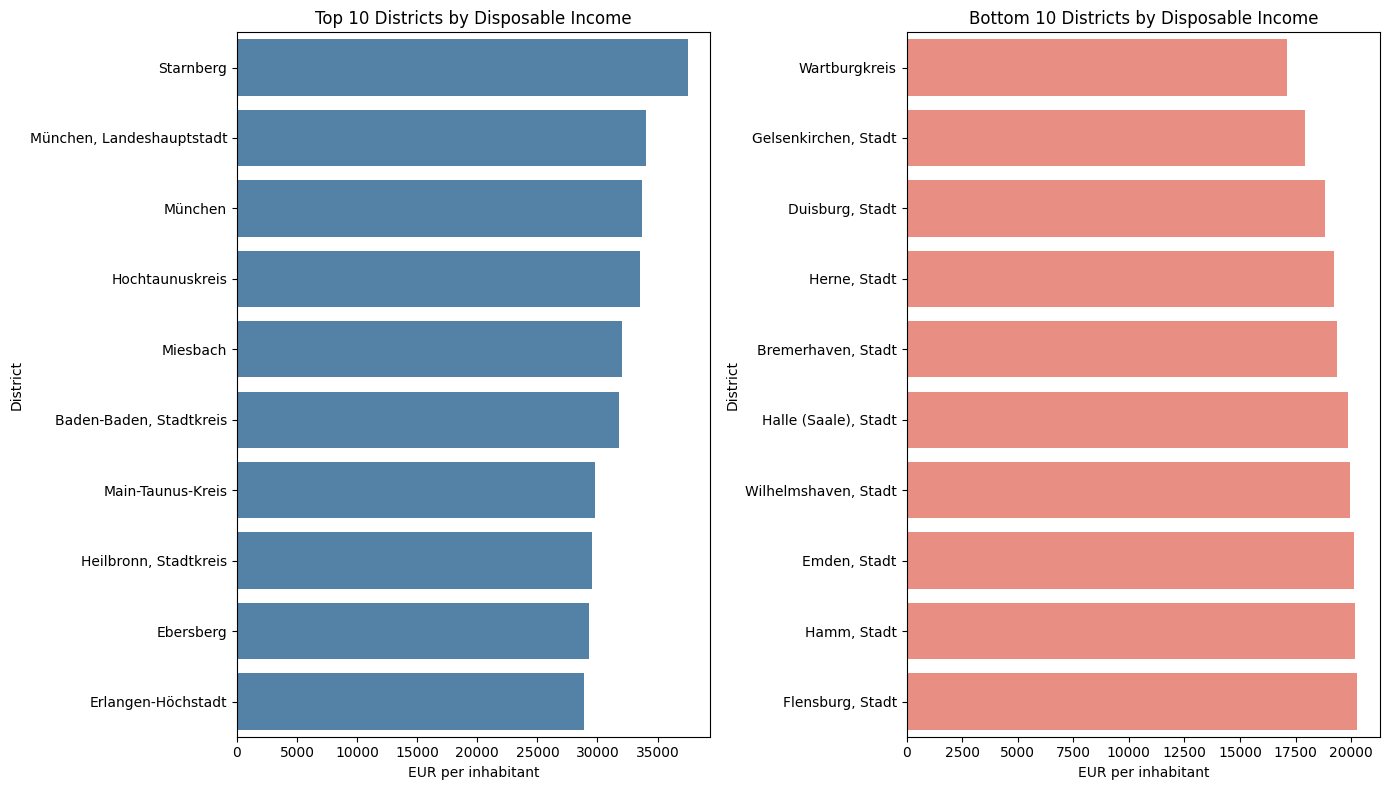

In [12]:
# Column names
income_col = "Disposable income of private households in 2021 (EUR per inhabitant)"

# 1) Summary statistics
print("Summary statistics for", income_col)
print(dist_df[income_col].describe().round(2))

# 2) Histogram
plt.figure(figsize=(6,4))
dist_df[income_col].hist(bins=30, edgecolor="black")
plt.title("Distribution of Disposible Income")
plt.xlabel("Disposible Income (EUR)")
plt.ylabel("Number of Districts")
plt.show()

# 3) Boxplot
plt.figure(figsize=(6,2))
dist_df.boxplot(column=income_col, vert=False)
plt.title("Boxplot of Disposible Income acorss Districts")
plt.xlabel("Disposible Income (EUR)")
plt.show()

# 4) Choropleth map
if income_col in geo_df.columns:
    ax = geo_df.plot(
        column=income_col,
        cmap="Blues",
        legend=True,
        figsize=(10, 9),
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("Disposable Income per Inhabitant (2021)", fontsize=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column '{income_col}' not found in geo_df. Did you merge dist_df with shapefile?")

# 5) Ranked barplots (Top 10 & Bottom 10)

# Sort and keep top/bottom 10 by income
top10 = dist_df.nlargest(10, income_col)
bottom10 = dist_df.nsmallest(10, income_col)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=False)

# Top 10
sns.barplot(
    y="Name",
    x=income_col,
    data=top10,
    ax=axes[0],
    color="steelblue"
)
axes[0].set_title("Top 10 Districts by Disposable Income")
axes[0].set_xlabel("EUR per inhabitant")
axes[0].set_ylabel("District")

# Bottom 10
sns.barplot(
    y="Name",
    x=income_col,
    data=bottom10,
    ax=axes[1],
    color="salmon"
)
axes[1].set_title("Bottom 10 Districts by Disposable Income")
axes[1].set_xlabel("EUR per inhabitant")
axes[1].set_ylabel("District")

plt.tight_layout()
plt.show()

**Degree of Urbanization vs. Prosperity**  

Population density serves as a proxy for **urban form** and the agglomeration forces that cities generate.  
Economic geography suggests that denser districts can benefit from thicker labor markets, greater firm diversity, and knowledge spillovers, which may translate into higher disposable incomes. At the same time, this link can be muted or reversed by high housing costs, legacy industry structures, or regional disparities (e.g., East–West patterns).  

The chart relates **degree of urbanization** to **disposable income**. It shows that most German districts cluster in the range of **low-to-moderate density with mid-level incomes**, while very dense urban districts are comparatively rare and not systematically associated with higher prosperity. This provides a structural perspective on how **urban form and economic well-being** intersect across regions.


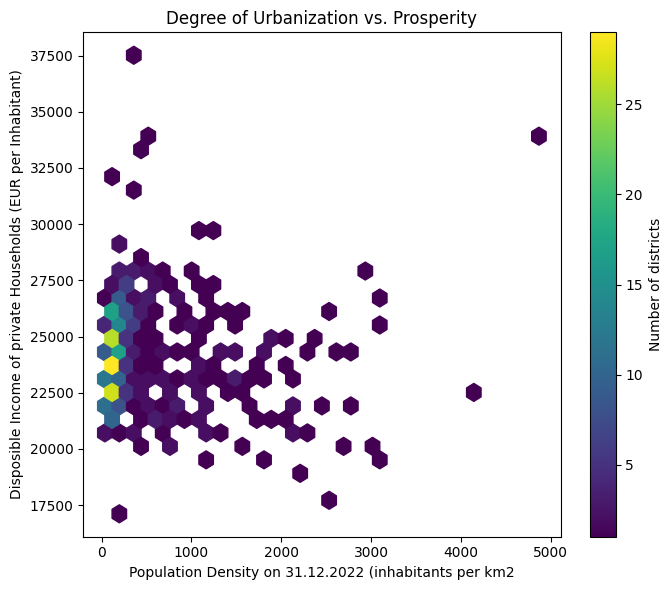

In [13]:
x = dist_df[den_col]
y = dist_df[income_col]

plt.figure(figsize=(7,6))
hb = plt.hexbin(
    x, y,
    gridsize=30,         # adjust resolution
    mincnt=1,            # hide empty bins
    cmap="viridis",      # any matplotlib colormap is fine
)
cb = plt.colorbar(hb)
cb.set_label("Number of districts")
plt.xlabel("Population Density on 31.12.2022 (inhabitants per km2")
plt.ylabel("Disposible Income of private Households (EUR per Inhabitant)")
plt.title("Degree of Urbanization vs. Prosperity")
plt.tight_layout()
plt.show()

**3.3 Interpretation — Disposable Income per Inhabitant**  

- **Average:** €24,157 (median €24,021), std ≈ €2,373.  
- **Range:** €17,116–€37,515.  
- **Regional divide:** Higher incomes in Bavaria (Munich, Starnberg) and regions around Frankfurt/Stuttgart; lower in North Rhine-Westphalia, northern Germany, and the East.  

Ranked barplots highlight extremes:  
- **Wealthiest districts:** Starnberg, Munich (city & surrounding), Hochtaunuskreis, Baden-Baden — all > €30,000.  
- **Lowest incomes:** Gelsenkirchen, Duisburg, Bremerhaven — €17,000–€19,000.  

The **hexbin chart** shows that most districts cluster in **low-to-moderate density with mid-level incomes**, while very dense urban districts are rare and not systematically linked to higher prosperity.  

Overall, disposable income reveals socio-economic and political divides: affluent districts tend to support incumbents and pro-market parties (CDU/CSU, FDP), while structurally weaker or post-industrial regions lean toward AfD or Die Linke (Batool, 2008; Batool & Sieg, 2009; Dorn et al., 2018).

## 3.4 Recipients of Social Welfare (SGB II)  

SGB II recipients measure **welfare dependency**, a marker of socio-economic vulnerability and a recurring point of political debate.  
- SPD, Greens, Die Linke emphasize social support.  
- CDU/CSU, FDP argue for stricter conditionality.  
- AfD links welfare debates to migration (Hohmeyer & Lietzmann, 2019; Dostal, 2017).  

Our descriptive analysis uses three views:  
1. **Summary statistics** — central tendency and spread of SGB II recipients across districts (incl. Histogram and Boxplot).  
2. **Choropleth map** — geographic variation, with higher reliance expected in eastern and post-industrial regions.  
3. **Scatterplot (SGB II × Foreign Residents)** — tests whether higher foreign shares align with greater welfare reliance, a politically sensitive linkage in German debates.  

Together, these perspectives highlight both the **geographic clustering** of welfare dependency and its **demographic correlates**, revealing structural divides with electoral relevance.  

Summary statistics for Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants)
count    400.00
mean      60.27
std       30.38
min       16.40
25%       38.78
50%       53.65
75%       74.62
max      205.30
Name: Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants), dtype: float64


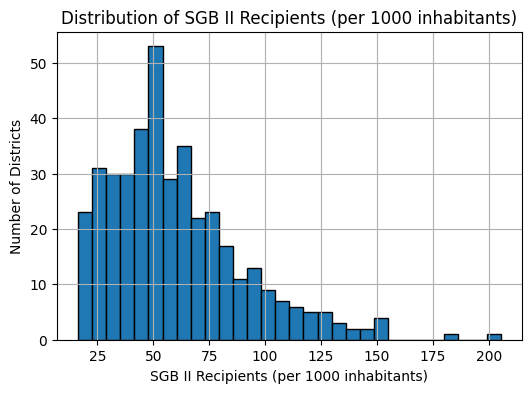

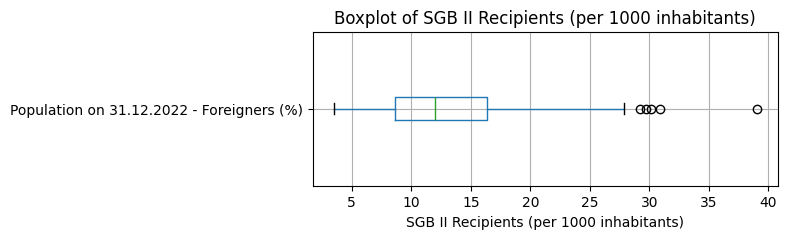

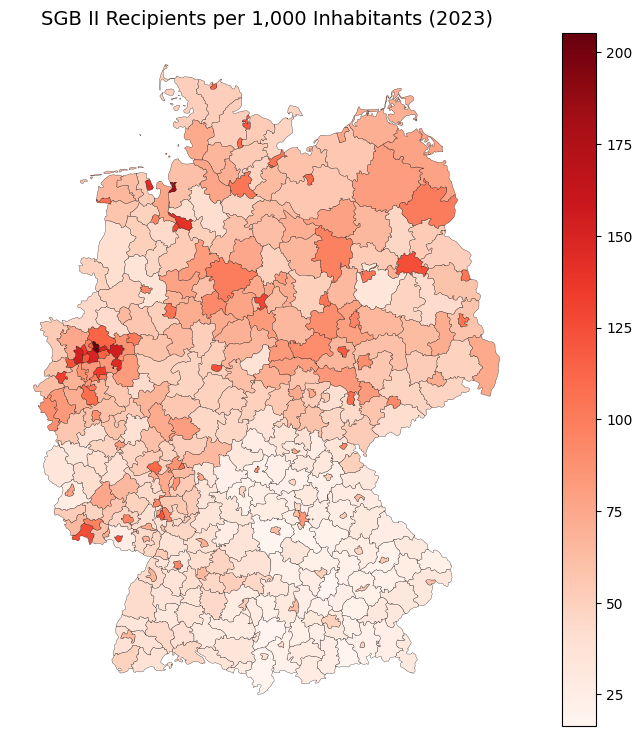

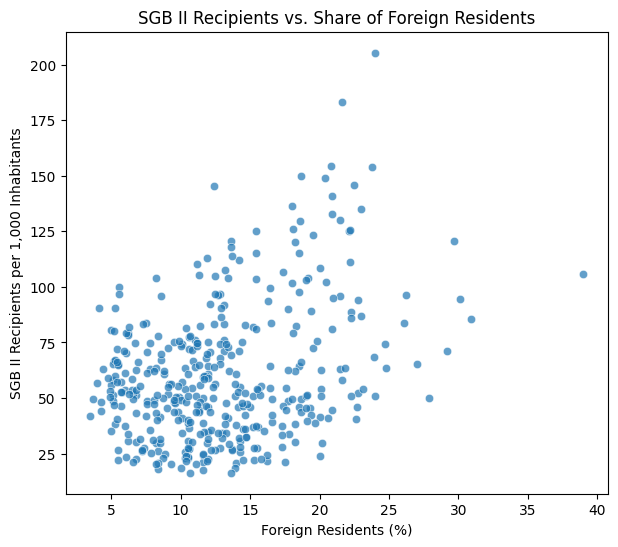

In [18]:
# Column names
sgb_col = "Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants)"

# 1) Summary statistics
print("Summary statistics for", sgb_col)
print(dist_df[sgb_col].describe().round(2))

# 2) Histogram
plt.figure(figsize=(6,4))
dist_df[sgb_col].hist(bins=30, edgecolor="black")
plt.title("Distribution of SGB II Recipients (per 1000 inhabitants)")
plt.xlabel("SGB II Recipients (per 1000 inhabitants)")
plt.ylabel("Number of Districts")
plt.show()

# 3) Boxplot
plt.figure(figsize=(6,2))
dist_df.boxplot(column=foreign_col, vert=False)
plt.title("Boxplot of SGB II Recipients (per 1000 inhabitants)")
plt.xlabel("SGB II Recipients (per 1000 inhabitants)")
plt.show()

# 3) Choropleth map
if sgb_col in geo_df.columns:
    ax = geo_df.plot(
        column=sgb_col,
        cmap="Reds",
        legend=True,
        figsize=
        (10, 9),
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("SGB II Recipients per 1,000 Inhabitants (2023)", fontsize=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column '{sgb_col}' not found in geo_df. Did you merge correctly?")

# 4) Scatterplot: SGB II vs. Share of Foreign Residents
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=dist_df,
    x=foreign_col,
    y=sgb_col,
    alpha=0.7
)
plt.title("SGB II Recipients vs. Share of Foreign Residents")
plt.xlabel("Foreign Residents (%)")
plt.ylabel("SGB II Recipients per 1,000 Inhabitants")
plt.show()


**3.4 Interpretation — SGB II Recipients**  

- **Average:** ~60 recipients per 1,000 inhabitants (median 54, std ≈ 30).  
- **Range:** 16 in the lowest districts to >200 in the most deprived.  
- **Geography:** Highest reliance in eastern Germany, Ruhrgebiet, and northern cities (Bremen, Bremerhaven); lowest in prosperous Bavarian and southern districts.  

The **scatterplot** shows a **positive association** between SGB II reliance and foreign population shares. While variation is wide, this illustrates how welfare and migration debates intersect spatially.   

Overall, SGB II reliance reflects both **socio-economic divides** (affluent south vs. struggling east/Ruhrgebiet) and **demographic dynamics** (diverse districts with higher welfare use). These divides overlap with electoral cleavages:  
- Welfare-heavy, diverse urban centers → contested by SPD/Greens vs. AfD.  
- Low-welfare, affluent districts → CDU/CSU and FDP strongholds.  

*Note:*  
The dataset also includes **SGB II recipients who are foreign residents**. Here we focus on **total recipients per 1,000 inhabitants** to capture the broader extent of welfare dependency. The subgroup variable remains relevant but is treated as an extension rather than the main indicator.  


## 3.5 Business Activity  

The **density of companies per 1,000 inhabitants** reflects local **entrepreneurial activity, service-sector development, and economic dynamism**.  
- High values: urban, service-oriented, or tourism regions.  
- Low values: rural or structurally weaker areas reliant on few large employers or agriculture.  

Politically, this indicator maps onto the **modernization divide**:  
- Dynamic, service-based regions → progressive or pro-business parties (SPD, Greens, FDP).  
- Traditional, low-density economies → conservative or populist parties (CDU/CSU, AfD) (Kowalewski, 2010, 2011).  

Our analysis explores how business density varies across districts, highlighting geographic contrasts and their electoral implications.  


Summary statistics — Business register 2021 - Total companies (per 1000 inhabitants)
count    400.00
mean      38.92
std        6.56
min       21.40
25%       35.38
50%       38.35
75%       41.52
max       74.40
Name: Business register 2021 - Total companies (per 1000 inhabitants), dtype: float64


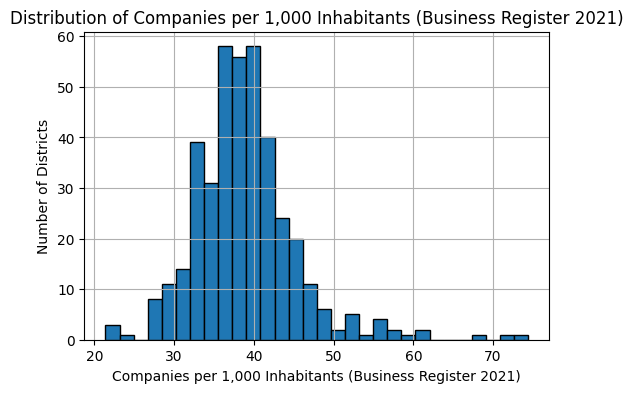

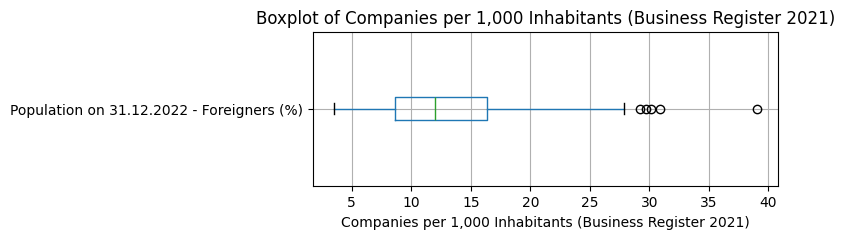

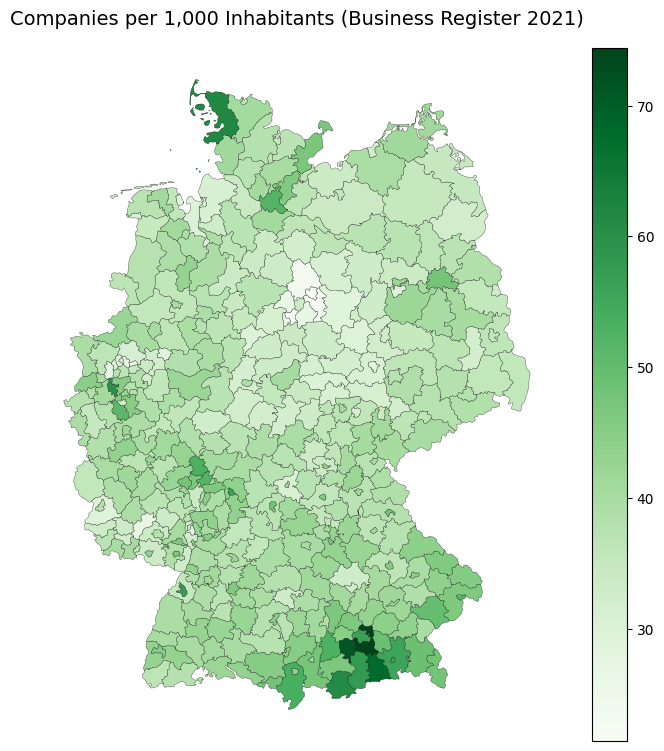

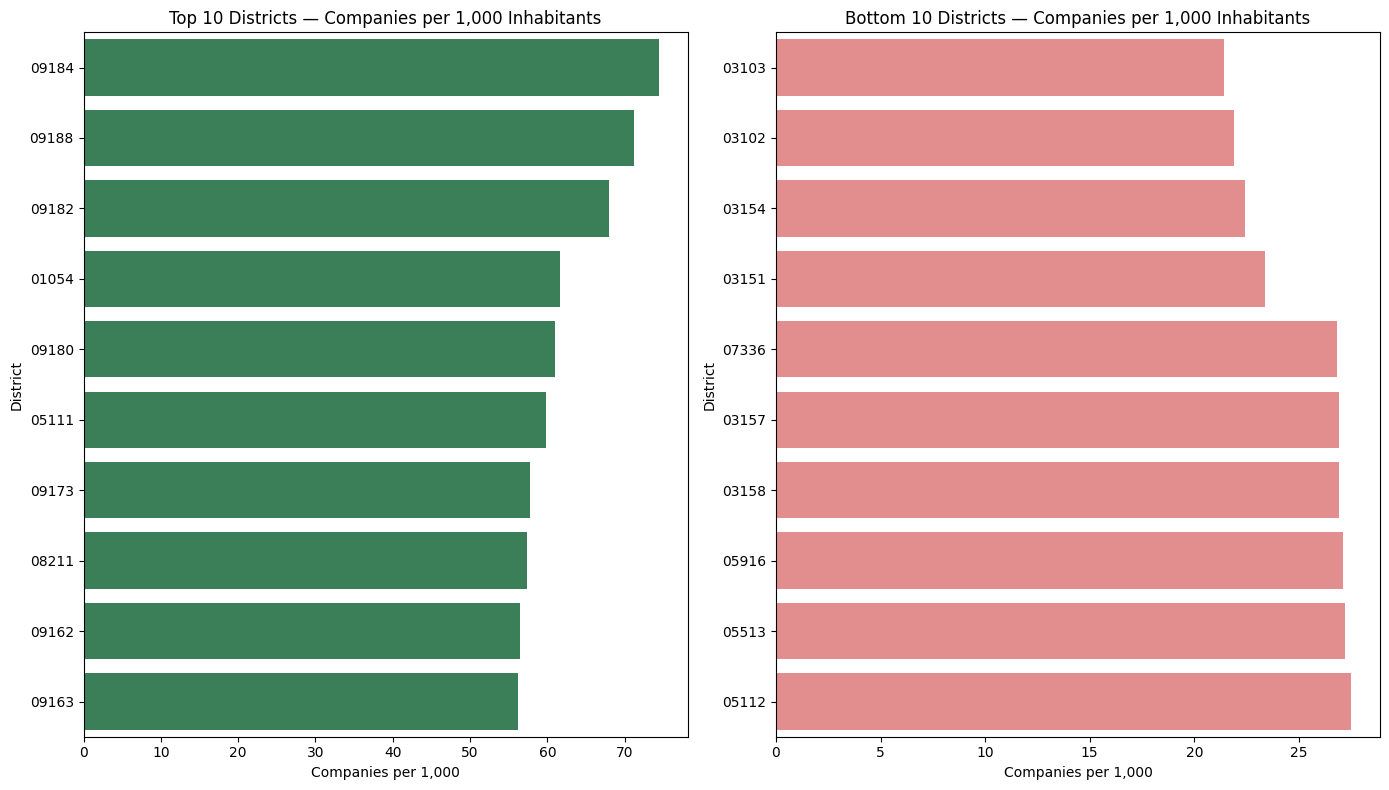

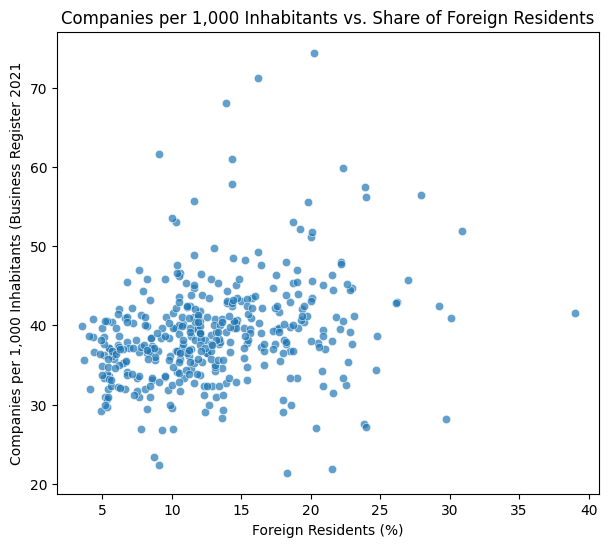

In [19]:
biz_col     = "Business register 2021 - Total companies (per 1000 inhabitants)"

# 1) Summary statistics 
print("Summary statistics —", biz_col)
print(dist_df[biz_col].describe().round(2))

# 2) Histogram
plt.figure(figsize=(6,4))
dist_df[biz_col].hist(bins=30, edgecolor="black")
plt.title("Distribution of Companies per 1,000 Inhabitants (Business Register 2021)")
plt.xlabel("Companies per 1,000 Inhabitants (Business Register 2021)")
plt.ylabel("Number of Districts")
plt.show()

# 3) Boxplot
plt.figure(figsize=(6,2))
dist_df.boxplot(column=foreign_col, vert=False)
plt.title("Boxplot of Companies per 1,000 Inhabitants (Business Register 2021)")
plt.xlabel("Companies per 1,000 Inhabitants (Business Register 2021)")
plt.show()

# 4) Choropleth map
if biz_col in geo_df.columns:
    ax = geo_df.plot(
        column=biz_col,
        cmap="Greens",
        legend=True,
        figsize=(10, 9),
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("Companies per 1,000 Inhabitants (Business Register 2021)", fontsize=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column '{biz_col}' not found in geo_df. Did you merge dist_df with the shapefile into geo_df?")

# 5) Ranked barplots (Top 10 & Bottom 10 by business density)
top10 = dist_df.nlargest(10, biz_col).copy()
bot10 = dist_df.nsmallest(10, biz_col).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=False)

sns.barplot(y=label_col, x=biz_col, data=top10, ax=axes[0], color="seagreen")
axes[0].set_title("Top 10 Districts — Companies per 1,000 Inhabitants")
axes[0].set_xlabel("Companies per 1,000")
axes[0].set_ylabel("District")

sns.barplot(y=label_col, x=biz_col, data=bot10, ax=axes[1], color="lightcoral")
axes[1].set_title("Bottom 10 Districts — Companies per 1,000 Inhabitants")
axes[1].set_xlabel("Companies per 1,000")
axes[1].set_ylabel("District")

plt.tight_layout()
plt.show()

# 4) Scatterplot: SGB II vs. Share of Foreign Residents
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=dist_df,
    x=foreign_col,
    y=biz_col,
    alpha=0.7
)
plt.title("Companies per 1,000 Inhabitants vs. Share of Foreign Residents")
plt.xlabel("Foreign Residents (%)")
plt.ylabel("Companies per 1,000 Inhabitants (Business Register 2021")
plt.show()

**3.5 Interpretation — Business Activity**  

- **Average:** ~39 companies per 1,000 inhabitants.  
- **Range:** ~21 in weaker districts to >74 in dynamic regions.  
- **Regional clustering:** Highest densities in Bavaria (Munich, Starnberg, Miesbach) and urban/tourism hubs (Düsseldorf, Baden-Baden); lowest in post-industrial areas of Lower Saxony and North Rhine-Westphalia (Duisburg, Gelsenkirchen, Wolfsburg).  

The **scatterplot** shows a **positive association between company density and foreign residents**: diverse urban areas are also centers of **entrepreneurship and migration**.  

This supports a dual pattern:  
- **Rural/post-industrial districts** with weaker business structures align with conservative or populist preferences.  
- **Cosmopolitan, dynamic economies** with high diversity favor progressive or pro-market parties (SPD, Greens, FDP), consistent with the modernization divide (Kowalewski, 2010, 2011).  

Entrepreneurship and diversity thus emerge as intertwined drivers of Germany’s electoral geography.  

## 3.6 Education  

Educational attainment is a key structural factor in German electoral behavior.  
Higher qualifications are linked to progressive parties (SPD, Greens, FDP), while lower or vocational attainment aligns more with conservative or populist preferences (CDU/CSU, AfD).  
**First-time voters and school graduates are especially important swing groups**, with their educational pathways shaping long-term political socialization (Ciechanowicz, 2017).  

We analyze the distribution of graduation levels across districts to highlight regional differences and their potential political implications.


Summary statistics — School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)
count    398.00
mean      31.41
std        8.69
min        9.50
25%       25.22
50%       29.95
75%       37.00
max       59.80
Name: School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%), dtype: float64


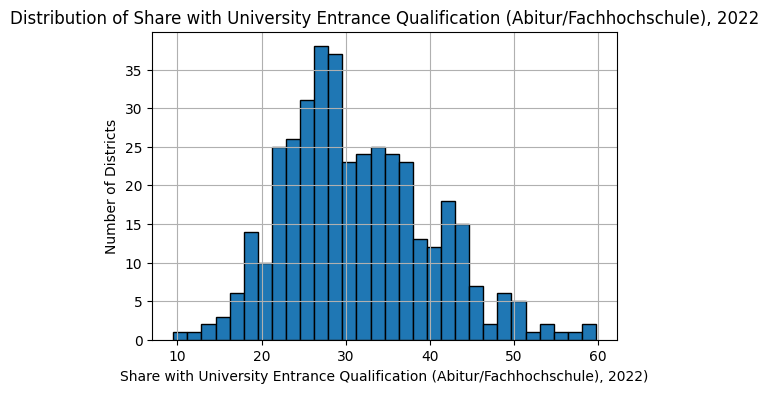

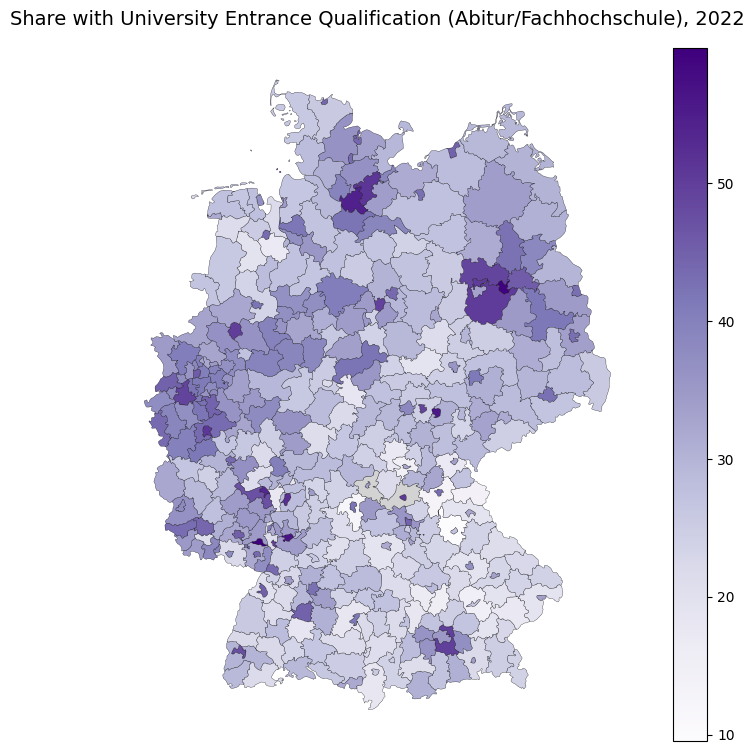

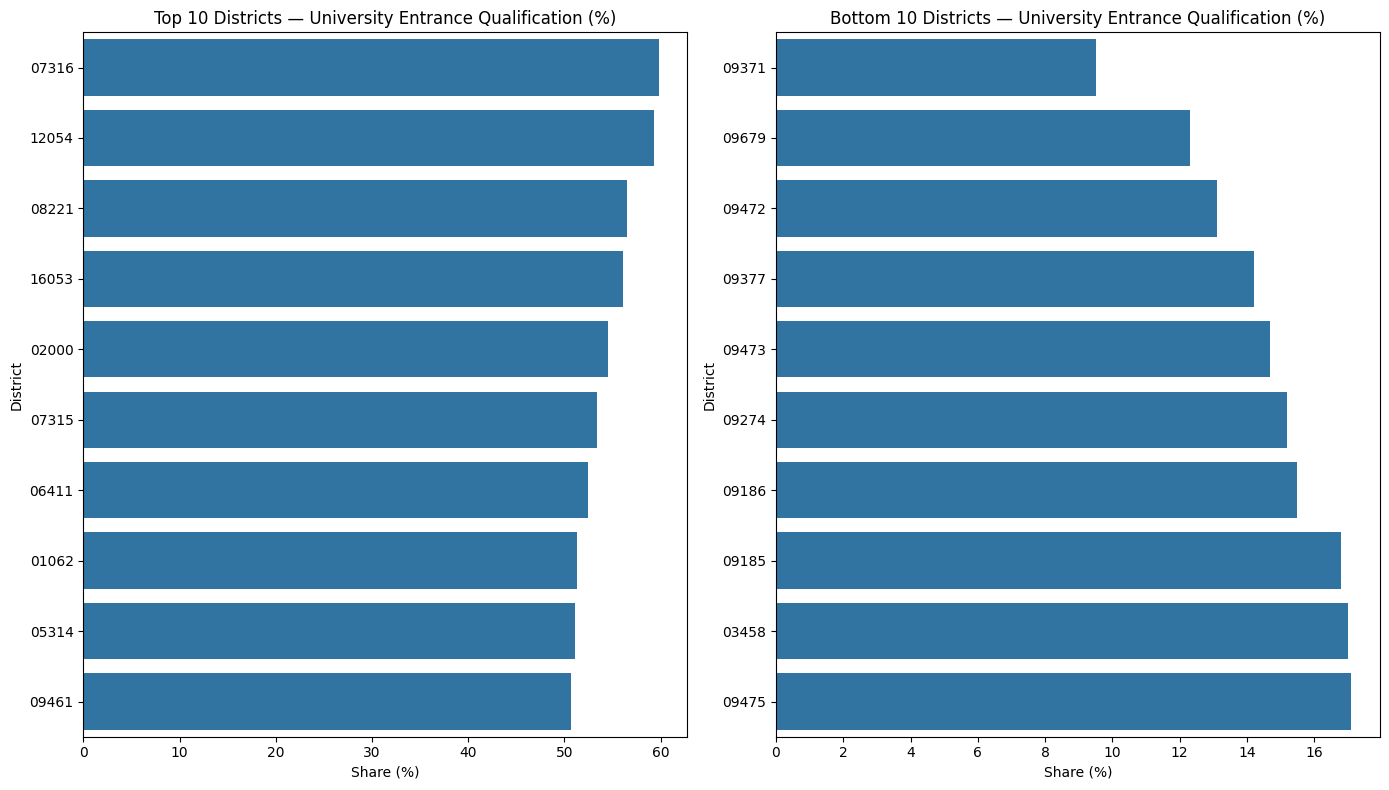

In [20]:
uni_col   = "School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)"

# 1) Summary statistics
print("Summary statistics —", uni_col)
print(dist_df[uni_col].describe().round(2))

# 2) Histogram
plt.figure(figsize=(6,4))
dist_df[uni_col].hist(bins=30, edgecolor="black")
plt.title("Distribution of Share with University Entrance Qualification (Abitur/Fachhochschule), 2022")
plt.xlabel("Share with University Entrance Qualification (Abitur/Fachhochschule), 2022)")
plt.ylabel("Number of Districts")
plt.show()

# 3) Choropleth map
if uni_col in geo_df.columns:
    ax = geo_df.plot(
        column=uni_col,
        cmap="Purples",            
        legend=True,
        figsize=(10, 9),
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("Share with University Entrance Qualification (Abitur/Fachhochschule), 2022", fontsize=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column '{uni_col}' not found in geo_df. Did you merge dist_df with the shapefile?")

# 4) Ranked barplots (Top 10 & Bottom 10 by educational attainment)
top10 = dist_df.nlargest(10, uni_col).copy()
bot10 = dist_df.nsmallest(10, uni_col).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=False)

sns.barplot(y=label_col, x=uni_col, data=top10, ax=axes[0])
axes[0].set_title("Top 10 Districts — University Entrance Qualification (%)")
axes[0].set_xlabel("Share (%)")
axes[0].set_ylabel("District")

sns.barplot(y=label_col, x=uni_col, data=bot10, ax=axes[1])
axes[1].set_title("Bottom 10 Districts — University Entrance Qualification (%)")
axes[1].set_xlabel("Share (%)")
axes[1].set_ylabel("District")

plt.tight_layout()
plt.show()


**Education vs. Welfare Dependency**  

Educational attainment is one of the strongest predictors of long-term political socialization and labor market outcomes.  
By comparing the share of graduates with a university entrance qualification to welfare dependency (SGB II recipients), we explore how **human capital and socio-economic vulnerability intersect at the district level**.  
This analysis allows us to move beyond single-variable descriptives and test whether regions with higher educational attainment also exhibit lower levels of welfare reliance, a link often assumed in political economy and electoral research.  
While correlations cannot establish causality, they provide an initial structural mapping of how education and welfare overlap across Germany’s regions.


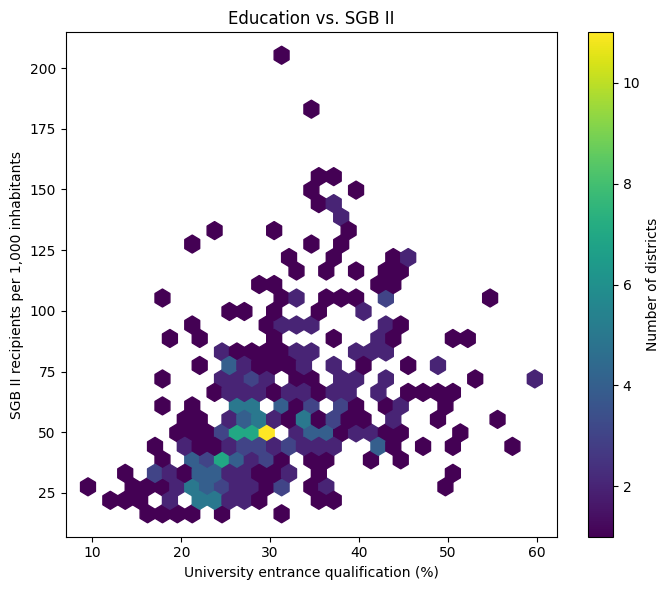

In [21]:
x = dist_df[uni_col]
y = dist_df[sgb_col]

plt.figure(figsize=(7,6))
hb = plt.hexbin(
    x, y,
    gridsize=30,         # adjust resolution
    mincnt=1,            # hide empty bins
    cmap="viridis",      # any matplotlib colormap is fine
)
cb = plt.colorbar(hb)
cb.set_label("Number of districts")
plt.xlabel("University entrance qualification (%)")
plt.ylabel("SGB II recipients per 1,000 inhabitants")
plt.title("Education vs. SGB II")
plt.tight_layout()
plt.show()

**Interpretation — Education vs. SGB II**  

The hexbin plot compares the share of school graduates with a university entrance qualification (%) and SGB II recipients per 1,000 inhabitants.  
Most districts cluster around 20–35% higher-education graduates and 40–70 welfare recipients.  
The wide spread shows no clear linear pattern: districts with both low and high education levels can still have varying welfare dependency.  
This highlights that education is important but not sufficient to explain welfare reliance, which is also shaped by labor markets and regional context.


**3.6 Interpretation — Education**  

- **Average:** ~31% of school graduates in 2022 obtained a university entrance qualification.  
- **Range:** From below 10% in some rural districts to nearly 60% in urban centers.  
- **Regional clustering:** Highest shares in metropolitan areas such as Berlin, Leipzig, and Munich; lowest in rural districts of Bavaria and eastern Germany.  
- **Hexbin analysis:** No strict linear link with SGB II dependency, but districts with lower attainment often coincide with higher welfare reliance, pointing to socio-economic vulnerability.
- **Missing Data:** Two districts lacked information on education; with 398 of 400 observations available, no imputation was applied, and the gap is not expected to distort results significantly.

This supports a dual pattern:  

- **Rural and structurally weaker regions** with lower educational attainment are more exposed to socio-economic risks and align with conservative or populist preferences.  
- **Urban, highly educated districts** with higher Abitur shares tend to favor progressive or pro-market parties (SPD, Greens, FDP).  

Educational attainment thus reinforces Germany’s **urban–rural and socio-economic divides**, shaping electoral cleavages through both opportunity structures and long-term political socialization (Ciechanowicz, 2017).


## Step 3 — Descriptive Analysis — Conclusion  

In Step 3, we analyzed six structural indicators: **population density, share of foreign residents, disposable income, recipients of social welfare (SGB II), business activity, and education**.  
Each highlights a distinct divide across German districts and connects to electoral cleavages identified in the literature:  

- **Population density** → urban–rural contrast.  
- **Foreign residents** → diverse western/southern cities vs. homogeneous eastern districts.  
- **Disposable income** → affluent southern regions vs. weaker Ruhrgebiet and eastern areas.
- **Recipients of social welfare (SGB II)** → highest reliance in eastern Germany, Ruhrgebiet, and northern cities vs. lowest reliance in prosperous Bavarian and southern districts.
- **Business activity** → entrepreneurial, service-driven urban economies vs. lagging rural/post-industrial regions.  
- **Education** → highly educated urban districts vs. rural and structurally weaker areas with lower graduation rates.  

Taken together, these indicators reveal persistent **structural polarization**: prosperous, diverse, and highly educated urban districts stand in contrast to vulnerable, rural, and post-industrial areas.  
These divides are socio-economic and demographic in nature and strongly linked to electoral behavior, reinforcing the modernization and urban–rural cleavages described in the literature.  


## Step 4 — Conclusion  

This assignment provided a **descriptive district-level analysis** using structural data from the Statistische Ämter des Bundes und der Länder.  
We first validated and prepared the dataset (ensuring the official 400 districts, correcting data types, and standardizing variables), then analyzed **six theoretically relevant indicators:**  
- **Population density** (urban–rural divide),  
- **Share of foreign residents** (migration and diversity),  
- **Disposable income** (prosperity and inequality),  
- **Recipients of social welfare (SGB II)** (socio-economic vulnerability),  
- **Business activity** (entrepreneurship and modernization),  
- **Education** (long-term political socialization and socio-economic opportunity).  

Where appropriate, we complemented descriptive statistics and maps with **scatter plots** (e.g., between foreign residents and SGB II recipients, between diversity and business activity, or between education and welfare dependency). These results should be seen as **correlations only**, not causal explanations. Unobserved variables such as regional policies, labor market structures, or migration histories may better explain some of the observed patterns.  

Overall, the findings highlight persistent **structural divides** across German districts:  
- Prosperous, diverse, entrepreneurial, and highly educated urban regions contrast with  
- Rural, post-industrial, and economically vulnerable areas.  

These divides mirror electoral cleavages described in the literature, though a fuller understanding of Germany’s electoral geography would require integrating additional variables and causal methods. 

## Limitations

This analysis was restricted to 6 of the 52 available variables.  
The selection was a deliberate choice to avoid overwhelming the scope of the assignment and to focus on indicators most relevant to structural divides discussed in the literature.  
While this approach allowed for a clearer line of argumentation, it necessarily left out other potentially important dimensions (e.g., housing, mobility, detailed age structures), which may provide additional explanatory power in future research.  


---

## Bibliography  

- Aristotle. (2009). *Nicomachean ethics* (W. D. Ross, Trans.). The Floating Press. (Original work published ca. 350 B.C.E.)  

- Batool, I. (2008). Bread, peace and the attrition of power: Economic events and German election results.  

- Batool, I., & Sieg, G. (2009). Bread and the attrition of power: Economic events and German election results. *Public Choice, 141*(1–2), 151–165. https://doi.org/10.1007/s11127-009-9443-x  

- Bundeswahlleiterin. (2024). *Administrative units for the 2024 European election*. https://www.bundeswahlleiterin.de/en/europawahlen/2024/kreise.html  

- Ciechanowicz, A. (2017). Predictability lost: the German political scene after the elections. *OSW Commentary, 254,* 22.11.2017.  

- Dorn, F., Fuest, C., Immel, L., & Neumeier, F. (2018). Inequality and extremist voting: Evidence from Germany.  

- Dostal, J. (2017). The German federal election of 2017: How the wedge issue of refugees and migration took the shine off Chancellor Merkel and transformed the party system. *The Political Quarterly, 88*(4), 589–602. https://doi.org/10.1111/1467-923x.12445  

- Haffert, L., & Mitteregger, R. (2023). Cohorts and neighbors: Urban–rural conflict along the age gradient. *Electoral Studies, 85,* 102705. https://doi.org/10.1016/j.electstud.2023.102705  

- Hohmeyer, K., & Lietzmann, T. (2019). Persistence of welfare receipt and unemployment in Germany: Determinants and duration dependence. *Journal of Social Policy, 49*(2), 299–322. https://doi.org/10.1017/S0047279419000242  

- Kellermann, K., & Winter, S. (2021). Immigration and anti-immigrant voting in the 2017 German parliamentary election. *German Economic Review, 23*(3), 341–401. https://doi.org/10.1515/ger-2021-0026  

- Kowalewski, J. (2010). Specialisation and employment development in Germany: Analysis at regional level.  

- Kowalewski, J. (2011). Specialization and employment development in Germany: An analysis at the regional level. *Jahrbücher für Nationalökonomie und Statistik, 231*(6), 789–811. https://doi.org/10.1111/j.1435-5957.2011.00355.x  

- Otto, A., & Steinhardt, M. (2014). Immigration and election outcomes—Evidence from city districts in Hamburg. *Regional Science and Urban Economics, 45,* 67–79. https://doi.org/10.1016/j.regsciurbeco.2014.01.004  

- Quast, H., Spangenberg, H., Mentges, H., Ordemann, J., & Buchholz, S. (2025). Inequality at the Transition to Higher Education in Germany: Social Differences by Prior Educational Pathways. *Social Inclusion.* https://doi.org/10.17645/si.8766  

- Schmitt-Beck, R., Roßteutscher, S., Schoen, H., Weßels, B., & Wolf, C. (2022). *The changing German voter* (p. 416). Oxford University Press. https://doi.org/10.1093/oso/9780198864514.001.0001  

- Statistische Ämter des Bundes und der Länder. (2024). *Structural indicators at district level*.  


